# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru
- **Поддержка CUDA**: А.Е.Григорьева admin@linkennt.ru
- **Ревизия**: 9

- **Другие ревизии**:
  - С 1 по 7: [Яндекс Диск](https://disk.yandex.ru/d/aZozDpBlzh_z1A)
  - 8 и далее: [GitHub releases page](https://github.com/LISA-ITMO/CGT4NN/releases)
<!-- please do not append text into this block -->

## TODO

> Gradient dropout - не все игроки не всегда получают выигрыш

- [x] Больше скрытых слоёв! (теперь их 5)
    - [x] В скрытых слоях 100-200 нейронов
    - [x] Попробовать что-то кроме 3 слоёв

Для этого мы вводим класс `AugmentedReLUNetworkMultilayer`, который расширяет
интерфейс `AugmentedReLUNetwork` параметром `hidden_layers_count`.

- [x] Взять датасет с плохим перфомансом
    - [x] Какой же из них с плохим перфомансом? Разве не все?
      - Я думаю, что #4, его $R^2$ ниже -15
    - $R^2$ увеличился с -15 до -2 🎉
- [ ] Применять gradient dropout к половине сети и ко всей сети
- [ ] Варьировать шум от 0 до 1 (а не 2)
- [x] $\alpha \in \{ 1, 1.12, 2 \}$
- [ ] Посмотреть, какой архитектурой решали MNIST character recognition на полносвязных сетях
    - [ ] Reference: https://github.com/ranimeshehata/Feed-Forward-Neural-Network-on-MNIST
- [x] Использовать sMAPE вместо $R^2$

- [ ] Использовать инициализацию *He* вместо *Xavier*
  - [ ] Сравнить
- [ ] Как оценить устойчивость случайной величины?
- [ ] На задаче классификации заменять класс $q$ на класс $r$ с заданной вероятностью, а вещественный шум использовать только для регрессии.


## Symmetric Mean Absolute Percentage Error (sMAPE)

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

Common in time series forecasting

$$ \mathrm{SMAPE} = {100 \over n}  \sum_{t=1}^{n} {{ |F_t - A_t| }\over{ (|A_t| + |F_t|)/2 }} $$

- $A_t$ - actual value
- $F_t$ - forecast value

Implementation of sMAPE is avaiable in the `torchmetrics` library:
https://torchmetrics.readthedocs.io/en/v1.0.0/regression/symmetric_mean_absolute_percentage_error.html

In [1]:
import torch
from torchmetrics import SymmetricMeanAbsolutePercentageError

target = torch.tensor([1, 10, 1e6])
preds = torch.tensor([0.9, 15, 1.2e6])
smape = SymmetricMeanAbsolutePercentageError()
smape(preds, target) # tensor(0.2290)

tensor(0.2290)

conf. $R^2$:

In [2]:
from sklearn.metrics import r2_score

r2_score(preds, target) # 0.9583327812227765

0.9583327812227765

## Setup

In [ ]:
from cgtnnlib.constants import LEARNING_RATE, RANDOM_STATE
import cgtnnlib.training as tr
import cgtnnlib.datasets as ds
from cgtnnlib.NoiseGenerator import target_dispersion_scaled_noise, stable_noise, no_noise_generator

iterations = 10
"Число моделей в каждом эксперименте"

epochs = 10
"Число эпох"

pp = [0.0, 0.5, 0.9]
"Набор гиперпараметров gradient dropout"

hidden_layers_count = 5
"Число скрытых слоёв"

inner_layer_size = 150
"Сколько нейронов в скрытых слоях"

# datasets = ds.datasets

datasets = [
    # ds.datasets[0], # 1
    # ds.datasets['StudentPerformanceFactors'], # 3
    ds.datasets['allhyper'], # 4
    # ds.datasets['wine_quality'], # 6
]
"Наборы данных, на которых проводить эксперимент"

output_dir = 'rev9.2'
"Папка с результатами"

def dir_path(d, p, n):
    return f'{output_dir}/dataset{d.number}_p{p}_noise{n.name}/'

def model_path(d, p, n, N):
    return f'{output_dir}/dataset{d.number}_p{p}_noise{n.name}/{N}.pth'

def report_filename(d, p, n, N):
    return f'dataset{d.number}_p{p}_noise{n.name}/{N}.json'

def report_path(d, p, n, N):
    return f'{output_dir}/{report_filename(d, p, n, N)}'


ng_makers = [
    lambda _: no_noise_generator,
    lambda d: target_dispersion_scaled_noise(
        dataset=d,
        factor=0.03,
        random_seed=RANDOM_STATE + 1,
    ),
    lambda d: stable_noise(
        dataset=d,
        factor=0.03,
        alpha=1,
        beta=0,
    ),
    lambda d: stable_noise(
        dataset=d,
        factor=0.03,
        alpha=1.12,
        beta=0,
    ),
    lambda d: stable_noise(
        dataset=d,
        factor=0.03,
        alpha=2.0,
        beta=1,
    ),
]
"Генераторы шумов для примешивания ко входам"

'setup complete'

'setup complete'

Я не понимаю, почему мы примешиваем шум именно ко входам.
Может, там и не так всё делается.

## Training

### Model B

- both take ~5m 06s to train 10 iterations
- both on both noises: about ~10m

<hr>

- `ds.datasets['StudentPerformanceFactors']` takes ~2m 30s to train 10 iterations
- `ds.datasets['wine_quality']` takes ~2m 36s to train 10 iterations

<hr>

- `ds.datasets['allhyper']` takes ~36m to train on all noise generators

### Model B*

3 hidden layers:
- ~15m 38s: Dataset #3, 5 ng_makers, $p \in \{ 0.0, 0.5, 0.9 \} $ 
- ~9m 30s: Dataset #3, 5 ng_makers, $p \in \{ 0.0, 0.5, 0.9 \} $ 

5 hidden layers:
- ~14m 10s: Dataset #3, 5 ng_makers, $p \in \{ 0.0, 0.5, 0.9 \} $ 



In [ ]:
## Training

import os

from cgtnnlib.Report import Report
from cgtnnlib.nn.AugmentedReLUNetworkMultilayer import AugmentedReLUNetworkMultilayer

for i, dataset in enumerate(datasets):
    for ng_maker in ng_makers:
        for p in pp:
            noise_generator = ng_maker(dataset)
            for iteration in range(iterations):
                os.makedirs(dir_path(dataset, p, noise_generator), exist_ok=True)
                report = Report(
                    dir=output_dir,
                    filename=report_filename(d=dataset, p=p,
                                             n=noise_generator, N=iteration)
                )
                tr.super_train_model(
                    make_model=lambda: AugmentedReLUNetworkMultilayer(
                        inputs_count=dataset.features_count,
                        outputs_count=dataset.classes_count,
                        p=p,
                        inner_layer_size=inner_layer_size,
                        hidden_layers_count=hidden_layers_count,
                    ),
                    model_path=model_path(d=dataset, p=p,
                                          n=noise_generator, N=iteration),
                    dataset=dataset,
                    report=report,
                    epochs=epochs,
                    learning_rate=LEARNING_RATE,
                    dry_run=False,
                    iteration=iteration,
                    noise_generator=noise_generator,
                )

'training complete'

N=9 #4 gStable4A2.0B1F0.03 p=0.9 E9/10 S252 Loss=0.0056@AugmentedReLUNetworkMultilayer
create_and_train_model(): saved model to rev9.2/dataset4_p0.9_noiseStable4A2.0B1F0.03/9.pth
Report saved to rev9.2/dataset4_p0.9_noiseStable4A2.0B1F0.03/9.json.


'training complete'

## Evaluation & Analysis

~2m 44s: Dataset #3, 5 ng_makers, $p \in \{ 0.0, 0.5, 0.9 \} $ 

In [ ]:
## Analysis

import json

import pandas as pd

import torch

import matplotlib.pyplot as plt

from cgtnnlib.Report import Report
from cgtnnlib.LearningTask import is_classification_task
from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt
from cgtnnlib.constants import NOISE_FACTORS
from cgtnnlib.evaluate import eval_report_at_path, super_eval_model
from cgtnnlib.nn.AugmentedReLUNetworkMultilayer import AugmentedReLUNetworkMultilayer


model_type = AugmentedReLUNetworkMultilayer



def read_json(path: str) -> dict:
    with open(path) as file:
        return json.load(file)

def summarize_series_list(series_list: list[pd.Series]):
    df = pd.DataFrame(series_list).T

    summary_df = pd.DataFrame({
        0.25: df.quantile(0.25, axis=1),
        0.75: df.quantile(0.75, axis=1),
        'mean': df.mean(axis=1),
    })

    return summary_df


def make_ax_drawer(
    read_json,
    dataset,
    ng_maker,
    p,
):
    noise_generator = ng_maker(dataset)

    def report_patha(N):
        return report_path(dataset, p, noise_generator, N)

    def model_patha(N):
        return model_path(dataset, p, noise_generator, N)

    def read_eval_from_iteration(n) -> pd.DataFrame:
        path = report_patha(n)
        report = Report.from_path(path)
        # model_path = model_path(n)
        
        model = model_type(
            inputs_count=dataset.features_count,
            outputs_count=dataset.classes_count,
            p=p,
            inner_layer_size=inner_layer_size,
            hidden_layers_count=hidden_layers_count,
        )
        model.eval()
        model.load_state_dict(torch.load(model_patha(n)))
        super_eval_model(
            dataset=dataset,
            model=model,
            report=report,
        )
        print('read_eval_from_iteration', path, n)
        return pd.DataFrame(read_json(path)['eval'])
    
    def read_loss_from_iteration(n) -> pd.DataFrame:
        path = report_patha(n)
        json = read_json(path)
        return pd.DataFrame({ 'loss': json['loss'] })

    # metric = 'loss'
    # metric = 'mse'
    metric = 'smape'

    files = [
        read_eval_from_iteration(n)
        for n in range(iterations)
    ]
            
    print(f'Processing {report_patha(0)}...')

    curve = summarize_series_list([file[metric] for file in files])

    def draw_ax(ax):
        plot_deviant_curves_on_ax_or_plt(
            ax_or_plt=ax,
            models=[{
                'curve': curve,
                'color': 'purple',
                'label': 'Среднее',
                'quantiles_color': 'pink',
                'quantiles_label': 'Квартили 0,25; 0,75', 
            }],
            X=curve.index,
            title='\n'.join([
                f'{noise_generator.name}, p = {p}',
            ]),
            xlabel='Итерация',
            ylabel=metric,
            quantiles_alpha=0.5,
        )
    
    return draw_ax

ax_drawers = [
    [
        [make_ax_drawer(read_json, dataset, ng_maker, p) for p in pp]
        for ng_maker in ng_makers
    ]
    for dataset in datasets
]

print(ax_drawers)

Report found at rev9.2/dataset4_p0.0_noiseNoNoise/0.json. Loading...
Report loaded.
Report saved to rev9.2/dataset4_p0.0_noiseNoNoise/0.json.
read_eval_from_iteration rev9.2/dataset4_p0.0_noiseNoNoise/0.json 0
Report found at rev9.2/dataset4_p0.0_noiseNoNoise/1.json. Loading...
Report loaded.
Report saved to rev9.2/dataset4_p0.0_noiseNoNoise/1.json.
read_eval_from_iteration rev9.2/dataset4_p0.0_noiseNoNoise/1.json 1
Report found at rev9.2/dataset4_p0.0_noiseNoNoise/2.json. Loading...
Report loaded.
Report saved to rev9.2/dataset4_p0.0_noiseNoNoise/2.json.
read_eval_from_iteration rev9.2/dataset4_p0.0_noiseNoNoise/2.json 2
Report found at rev9.2/dataset4_p0.0_noiseNoNoise/3.json. Loading...
Report loaded.
Report saved to rev9.2/dataset4_p0.0_noiseNoNoise/3.json.
read_eval_from_iteration rev9.2/dataset4_p0.0_noiseNoNoise/3.json 3
Report found at rev9.2/dataset4_p0.0_noiseNoNoise/4.json. Loading...
Report loaded.
Report saved to rev9.2/dataset4_p0.0_noiseNoNoise/4.json.
read_eval_from_ite

### Trying 5 layers

Smape goes down (p = 0):
- 0.1 -> 0.08
- 0.10 -> 0.085
- 0.10 -> 0.085
- 0.09 ~> 0.095 (goes up on Stble4A.12B0F0.03)
- 0.11 -> 0.085

In [15]:
import numpy as np
np.abs(np.array([
    0.1 - 0.08,
    0.1 - 0.085,
    0.10 - 0.085,
    0.09 - 0.095,
    0.11 - 0.085,
])).mean()

0.016

So we gain ~0.016 of sMAPE for adding 2 layers

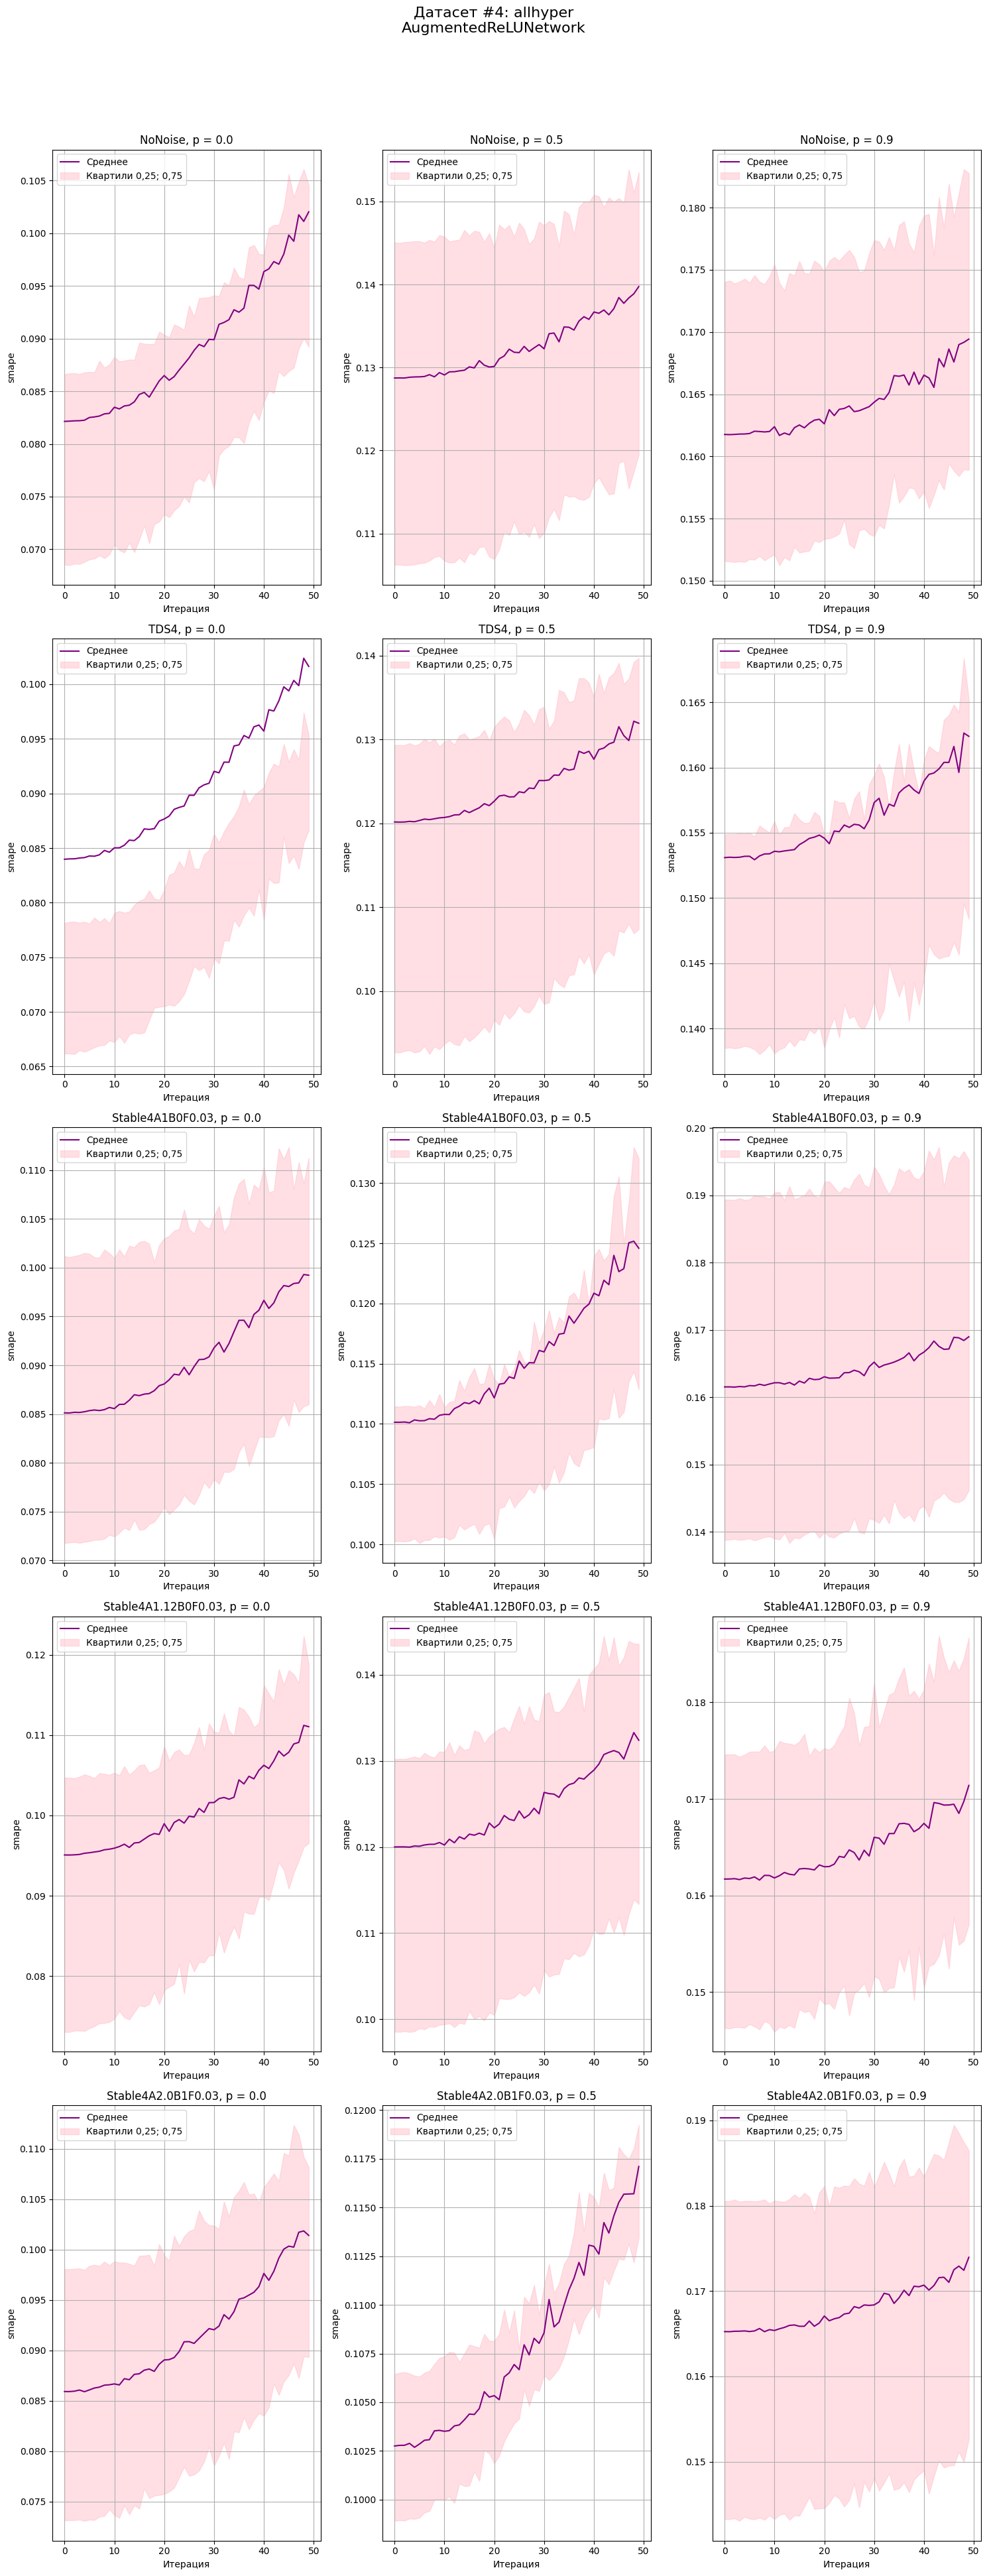

In [10]:
(nrows, ncols) = (
    len(ax_drawers[0]),
    len(ax_drawers[0][0]),
)

(nrows, ncols)

for i, dataset in enumerate(datasets):
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 40))

    for j in range(nrows):
        for k in range(ncols):
            ax_drawers[i][j][k](axes[j, k])
    
    fig.suptitle(f'Датасет #{dataset.number}: {dataset.name}\nAugmentedReLUNetwork', fontsize=16)
    plt.tight_layout(rect=[0, 0.01, 1, 0.95]) # rect adjusts space for suptitle
    plt.show()

## References

1. Chambers, J. M., Mallows, C. L., & Stuck, B. W. (1976). A method for simulating stable random variables. *Journal of the American Statistical Association*, *71*(354), 340-344.
2. M. Firouzi, A. Mohammadpour. A Survey on Simulating Stable Random Variables. URL: https://www.semanticscholar.org/reader/11a1e93642dc0a5c94e6906bcca5e4d25d4e9d46